## Fukuro Omnivision Modeling 
by Marco Aland Adinanda

### A. Introduction

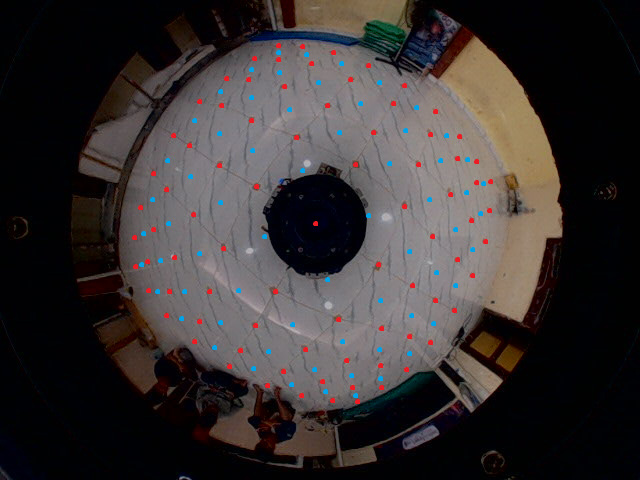

- Training data: Red dot
- Testing data: Blue dot

### B. Importing and Visualize Dataset

In [1]:
import pandas as pd
import numpy as np

# Load the dataset
train_path = "dataset/training_set.csv"
test_path = "dataset/testing_set.csv"

data_train = pd.read_csv(train_path, delimiter=";")
data_train['distance'] = np.sqrt(data_train['field_x']**2 + data_train['field_y']**2)

data_test = pd.read_csv(test_path, delimiter=";")
data_test['distance'] = np.sqrt(data_test['field_x']**2 + data_test['field_y']**2)

# df = pd.concat([data_train, data_test])

# df.head()

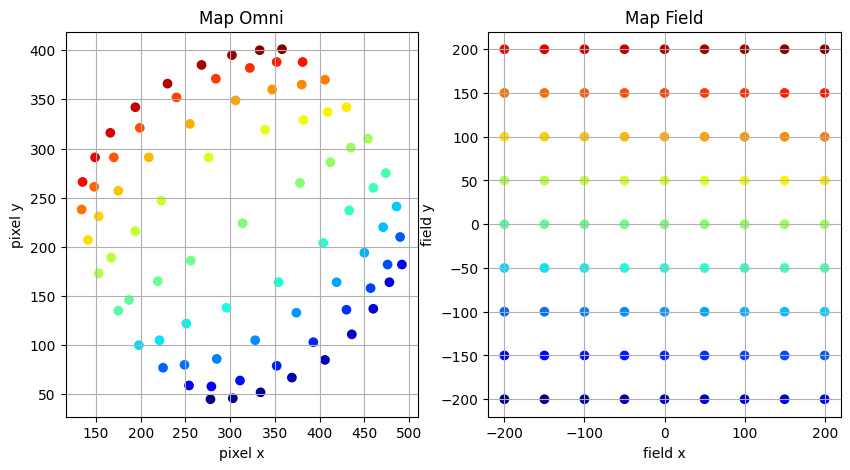

In [2]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_title("Map Omni")
ax1.set_xlabel("pixel x")
ax1.set_ylabel("pixel y")
ax1.scatter(data_train['pixel_x'], data_train['pixel_y'], c=data_train.index, cmap='jet')#, edgecolors='black')
ax1.grid()

ax2.set_title("Map Field")
ax2.set_xlabel("field x")
ax2.set_ylabel("field y")
ax2.scatter(data_train['field_x'], data_train['field_y'], c=data_train.index, cmap='jet')#, edgecolors='black')
ax2.grid()


### C. Modeling using Gausian Regressor

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [4]:
# Define the features and the target


X_train = data_train[['pixel_x', 'pixel_y']].values  # feature
y_train = data_train['distance'].values  # target

X_test = data_test[['pixel_x', 'pixel_y']].values  # feature
y_test = data_test['distance'].values  # target

# Train test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Possible length_scale values to search 
param_grid = {
    "kernel": [C(1.0) * RBF(length_scale=l) for l in np.logspace(-2, 2, 10)]
}

# Grid search to find best RBF kernel parameters
best_score = float('inf')
best_kernel = None

for kernel in param_grid["kernel"]:
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-6)
    gpr.fit(X_train, y_train)
    y_pred = gpr.predict(X_test)
    score = mean_absolute_error(y_test, y_pred)

    if score < best_score:
        best_score = score
        best_kernel = kernel

print(f"Best Kernel: {best_kernel}")
print(f"Best MAE: {best_score:.6f}")

# Train regressor with best kernel parameters
gpr_best = GaussianProcessRegressor(kernel=best_kernel, n_restarts_optimizer=10, alpha=1e-6)
gpr_best.fit(X_test, y_test)

Best Kernel: 1**2 * RBF(length_scale=4.64)
Best MAE: 5.700477


GaussianProcessRegressor(alpha=1e-06, kernel=1**2 * RBF(length_scale=4.64),
                         n_restarts_optimizer=10)

In [5]:
import plotly.graph_objects as go

# Define the grid range
x_min, x_max = X_test[:, 0].min(), X_test[:, 0].max()
y_min, y_max = X_test[:, 1].min(), X_test[:, 1].max()

# Grid mesh for prediction
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, 50), np.linspace(y_min, y_max, 50))
X_pred = np.c_[x_grid.ravel(), y_grid.ravel()]

# Retrieve the prediction 
y_pred, sigma = gpr_best.predict(X_pred, return_std=True)
y_pred = y_pred.reshape(x_grid.shape)

# 3D Plot
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=X_test[:, 0], 
    y=X_test[:, 1], 
    z=y_test, 
    mode='markers',
    marker=dict(size=5, color='red', opacity=0.8),
    name="Actual Data"
))

fig.add_trace(go.Surface(
    x=x_grid, 
    y=y_grid, 
    z=y_pred, 
    colorscale='viridis', 
    opacity=0.8
))

fig.update_layout(
    title="Predicted Omnivision Distance Based on Pixel X and Pixel Y Coordinates",
    scene=dict(
        xaxis_title='Pixel X',
        yaxis_title='Pixel Y',
        zaxis_title='Distance',
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()


### D. Model Evaluation

In [6]:
# Model evaluation using validation test
# df_test = pd.read_csv(test_path, delimiter=";")
# df_test['distance'] = np.sqrt(df_test['field_x']**2 + df_test['field_y']**2)

# X_val = df_test[['pixel_x', 'pixel_y']].values
# y_val = df_test['distance'].values

X_val = X_test
y_val = y_test

y_pred = gpr_best.predict(X_val)

mae_val = mean_absolute_error(y_val, y_pred)

print("### Model Distance Error ###")
print(f"Mean Absolute Error (MAE): {mae_val:.3f} cm")

### Model Distance Error ###
Mean Absolute Error (MAE): 0.000 cm


In [14]:
# Save the best model
import pickle

with open("models/gpr_model_train_test_no_mix.pkl", "wb") as file:
    pickle.dump(gpr_best, file)
print("Model saved successfully!")

Model saved successfully!


### E. Load and Self Input Test

In [15]:
# Load the model
with open("models/gpr_model_train_test_no_mix.pkl", "rb") as file:
    gpr_loaded = pickle.load(file)
print("Model loaded successfully!")

Model loaded successfully!


In [16]:
# Manual check
def predict_distance(model, pixel_x, pixel_y):
    input_data = np.array([[pixel_x, pixel_y]])
    predicted_distance, _ = model.predict(input_data, return_std=True)
    return predicted_distance[0]

# Define testing variable
test_x, test_y = 426, 293
true_value = 125

# Predict the distance
test_pred = predict_distance(gpr_loaded, test_x, test_y)
print(f"Predicted Distance: {test_pred:.3f} cm")
print(f"Error: {abs(true_value - test_pred):.3f} cm")

Predicted Distance: 123.979 cm
Error: 1.021 cm
